# **CSE 5522 Lab #4: Neural Networks**

Author: Stephen Zheng<br>
The goals of this lab are to familarize you with:

* Perceptron Learning Rule
* Neural Network toolkits (PyTorch, specifically)
* Supervised learning with data related to speech

**Initial notes**

* (If you are using Google Colab) Make a copy of this page in your google drive so that you can edit it.

* While not completely necessary for this assignment, you may want to familiarize yourself with the following packages: [numpy](https://numpy.org), [scikit-learn](https://scikit-learn.org), [pandas](https://pandas.pydata.org), [matplotlib](https://matplotlib.org).
 * Especially numpy, many of the calculations in this (and later) lab can be done in one line using numpy. Whereas raw python may require 5-10x that.

* Feel free to (please do!) change the structure of the document below. Especially, add code sections to break your code into logical pieces and add text sections to explain your code or results

---
---



# **Part 1: Perceptron Learning Rule (0 pts)**

You won't need anything from part 1 of the Hands-On to complete this lab.

---
---

# **Part 2: Vowel Classification (0 pts)**

In this section, you will look at some actual (noisy) vowel formant data.

Formants, as we use them here, are the local maxima, or broad peaks, in a sound's spectrogram. They are related to the harmonic structure of sounds and so we expect them to be highly related to speech. So we will attempt to use formant pairs (the two highest/most powerful, peaks) to predict vowels.

Go to the International Phonetic Alphabet (IPA) vowel chart at https://en.wikipedia.org/wiki/IPA_vowel_chart_with_audio and play the sounds.  The chart is written in IPA, but here are the two letter (ARPABET) symbols for some of the vowels of English: iy, ih, ey, eh, ah, ao, ow, uw, ax.

Vowels are produced by shaping the vocal tract so some of their features are:

|Vowel|Tongue Height|Tongue Depth|Lip Shape|
|---|---|---|---|
|iy|close|front|unrounded|
|ih|near-close|front|unrounded|
|ey|close-mid|front|unrounded|
|eh|open-mid|front|unrounded|
|ah|open|back|rounded|
|ao|open-mid|back|rounded|
|ow|close-mid|back|rounded|
|uw|close|back|rounded|
|ax|mid|central|unrounded|

I've prepared a csv datafile with the following features:
* Vowels
 * 'vowel': Two-letter vowel identifier (e.g., 'iy', 'ih', etc.)
* Formants
 * 'f1': Strongest formant (in Hz)
 * 'f2': Second strongest formant (in Hz)
* Tongue Height
* Tongue Depth
* Lip Shape
 * You won't be using these in the current form of the lab, so they can be ignored.
---

First, let's read in the data.



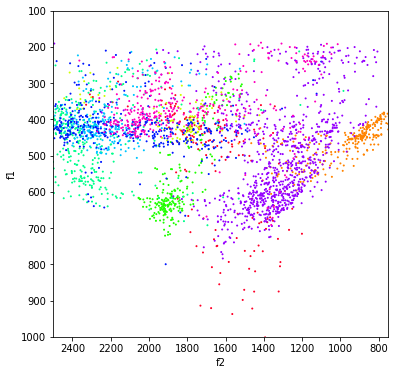

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# first, read in the data and build a scatterplot showing the vowel formants
import pandas as pd
url='https://raw.githubusercontent.com/efosler/cse5522data/master/vowelfmts.csv'
df=pd.read_csv(url)
#display(df.head());
# This function will plot the vowels as a scatterplot with different colors
# using the traditional F2 vs F1 inverted plot.  This puts high (close) vowels
# at the top of the plot and low vowels (open) at the bottom.  Front vowels
# are to the left; back vowels to the right.  Optionally can plot a boundary.

def plotvowels(df,weights=None):
  # this next bit converts the label into a colormap value between 0 and 1
  vowels=df['vowel'].unique()
  vmap={}
  for i in range(vowels.shape[0]):
    vmap[vowels[i]]=float(i)/float(vowels.shape[0]-1)
  df['color']=df['vowel'].map(vmap)
  # plot the scatterplot
  plt.figure(num=1,figsize=(6,6))
  plt.scatter(df['f2'],df['f1'],s=1,c=df['color'],cmap='gist_rainbow')
  plt.xlabel('f2')
  plt.ylabel('f1')
  plt.gca().set_ylim([100,1000])
  plt.gca().set_xlim([750,2500])
  plt.gca().invert_xaxis()
  plt.gca().invert_yaxis()
  if weights is not None:
    dmin=df['f2'].min()
    dmax=df['f2'].max()
    plt.plot(np.array([dmin,dmax]),
             np.array([-(dmin*weights[0]+weights[2])/(weights[1]),
                       -(dmax*weights[0]+weights[2])/(weights[1])]),
             'b--'
             )

# Plot the vowel data.  Compare against the IPA chart online.
plotvowels(df)

The chart above shows examples of vowels (iy, ih, ...) as colors, along with the formants (f1,f2) we will use to predict them.

You will notice that the vowel classes aren't linearly separable. Which, as we know, means a simple single layer perceptron (as you developed for part 1) cannot solve it. Looking at the above diagram, with the different classes so mixed together, it would not even be able to make a decent approximation.

---

**2.2** To start, a bit of code to extract data and create training/test sets.

In [ ]:
#Extract fundamental frequencies
data_f1=np.array(df['f1'],dtype='float32')
data_f2=np.array(df['f2'],dtype='float32')
data_formants=np.transpose(np.vstack((data_f1,data_f2)))
del data_f1, data_f2 #Delete these so they don't hang around poluting the namespace
labels_formants=['f1','f2']
print(labels_formants)
#display(data_formants)

#Extract vowel, it's categorical so we create dummy variables for each vowel
data_vowels=pd.get_dummies(df['vowel'])
labels_vowels=list(data_vowels.columns)
data_vowels=np.array(data_vowels,dtype='int_')
print(labels_vowels)
#display(data_vowels)

#Sometimes it's also useful to map categorical variables to (column) index
#  (You will need this in part 4!)
index_vowels={label:idx for idx,label in enumerate(labels_vowels)}
data_vowels_idx=np.array([index_vowels[vwl] for vwl in df['vowel']],dtype='int_')
#display(data_vowels_idx)

from sklearn.model_selection import train_test_split
train_formants, test_formants, train_vowels, test_vowels, train_vowels_idx, test_vowels_idx = \
  train_test_split(data_formants,data_vowels,data_vowels_idx)


['f1', 'f2']
['ah', 'ao', 'ax', 'eh', 'ey', 'ih', 'iy', 'ow', 'uw']


In [ ]:
#display(train_formants, test_formants)
#display(train_vowels, test_vowels)
#display(train_vowels_idx, test_vowels_idx)

---
---

# **Part 3: PyTorch Neural Networks** (0 pts)

If you didn't get a chance during the Hands-On, go back and look at part 3 from the Hands-On. You'll be using/modifying that example code for Part 4 of the lab.


In [ ]:
#Basic PyTorch setup
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Use GPU if available
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

---
---

# **Part 4: MLP classification of vowels (60 pts)**

In this section we will combine together what you learned in Parts 2 and 3.

Previously, in Part 2 we noted the vowel data was not linearly separable based solely on the formants, hence could not be solved with a single-layer percepton.

We then proceeded to manually separate the data based on vocal tract features, then manually recombine the results to get vowel predictions.

In this Part 4 we will take a different approach: We will instead use a *multi-layer perceptron* which should be capable of solving even non-linearly separable problems.

This should allow us to predict vowel classes directly from formants, ignoring the vocal tract features completely.

---

**4.1** With the formant data from Part 2, use PyTorch to construct a 2-layer MLP with 100 hidden units, predicting the vowel class.

The traditional way to handle multi-class (non-binary) problems such as this is to have a softmax output with a cross entropy loss.  Pytorch does this using the [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) function, which expects as its input the linear layer (it builds the softmax function into the loss).

You will need to modify the hands-on example to use softmax output with cross-entropy as loss function. Review the linked documentation (you will need to be careful of the format expected for various inputs!)

Report and discuss results on the test set.

**Note:** Part of this task involves adapting what you learned in Part 3, as well as looking up documentation/examples for PyTorch to make the required modifications.

In [ ]:
# Your MLP code here
class MLP(nn.Module):
    def __init__(self, input_dim = 2, hid_dim=100, output_dim=9):
        # initialze the superclass
        super(MLP, self).__init__()
        # this will create a linear layer with input_dim x hid_dim parameters
        # in addition to a bias unit with hid_dim parameters
        self.lin1 = nn.Linear(input_dim, hid_dim)
        # same thing here except hid_dim x output_dim
        self.lin2 = nn.Linear(hid_dim, output_dim)

    # this is where the meat of the action is
    def forward(self, x):
        x = self.lin1(x)  # linear combination of inputs
        x = torch.sigmoid(x) # then through sigmoid - output of first layer
        x = self.lin2(x) # linear combination of hidden units
        #x = torch.sigmoid(x) # then through sigmoid - net output
        return x

In [ ]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 1)

In [ ]:
# Need to normalize train_formants and test_formants
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(train_formants)
normal_train_formants = scaler.transform(train_formants)
#display(normal_train_formants)
scaler = preprocessing.MinMaxScaler().fit(test_formants)
normal_test_formants = scaler.transform(test_formants)
#display(normal_test_formants)
x_train = torch.tensor(normal_train_formants)
y_train = torch.tensor(train_vowels_idx)
x_test = torch.tensor(normal_test_formants)
y_test = torch.tensor(test_vowels_idx)
#display(x_train, y_train)
#display(x_test, y_test)

In [ ]:
model = MLP()
weights_init(model)
loss_func = nn.CrossEntropyLoss() # Use Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

In [ ]:
# Training with mini-batch
def training(x , y, epochs, model, loss_func, optimizer):
  N = x.size(0)
  for i in range(epochs):
    mini_batch_size=50
    order=np.random.permutation(N)
    for j in range(0,N,mini_batch_size):
      data_points = order[j:min(j+mini_batch_size,N)]
      x_var = Variable(x[data_points], requires_grad=False)
      y_var = Variable(y[data_points], requires_grad=False)

      optimizer.zero_grad()
      y_hat = model(x_var)
      loss = loss_func.forward(y_hat, y_var)
      loss.backward()
      optimizer.step()

    if i % 5000 == 0:
      print("Epoch: {0}, Loss: {1}, ".format(i, loss.data.cpu().numpy()))

In [ ]:
# Return the accuracy
def accuracy(x, y, model):
  correct = 0
  x_var = Variable(x, requires_grad=False)
  y_var = Variable(y, requires_grad=False)
  y_hat = model(x_var.float())
  y_var = y_var.long()
  prediction_vowels_idx = []
  prediction = y_hat.detach().numpy()
  for i in range (prediction.shape[0]):
    #Find the max output and append to the list
    prediction_vowels_idx.append(np.where(prediction[i]==max(prediction[i])))
  total = len(prediction_vowels_idx)
  for x in range (total):
    correct += 1 if prediction_vowels_idx[x][0][0] == int (y_var[x]) else 0
  return correct/total

In [ ]:
# Train the model 100000 times
training(x_train, y_train, 100001, model, loss_func, optimizer)

Epoch: 0, Loss: 2.1563479900360107, 
Epoch: 5000, Loss: 1.0771031379699707, 
Epoch: 10000, Loss: 0.703187108039856, 
Epoch: 15000, Loss: 1.0360829830169678, 
Epoch: 20000, Loss: 1.1536495685577393, 
Epoch: 25000, Loss: 0.6304243803024292, 
Epoch: 30000, Loss: 0.7959765791893005, 
Epoch: 35000, Loss: 0.7909039855003357, 
Epoch: 40000, Loss: 0.5782797336578369, 
Epoch: 45000, Loss: 0.5946545600891113, 
Epoch: 50000, Loss: 0.620069146156311, 
Epoch: 55000, Loss: 0.9074170589447021, 
Epoch: 60000, Loss: 0.5639670491218567, 
Epoch: 65000, Loss: 0.7767226696014404, 
Epoch: 70000, Loss: 1.1916167736053467, 
Epoch: 75000, Loss: 1.2324934005737305, 
Epoch: 80000, Loss: 0.6780978441238403, 
Epoch: 85000, Loss: 0.5405256152153015, 
Epoch: 90000, Loss: 0.6992953419685364, 
Epoch: 95000, Loss: 0.8019039630889893, 
Epoch: 100000, Loss: 0.9636530876159668, 


**It took almost 40 min to train. Super long time...**

Epoch: 0, Loss: 2.1563479900360107,

Epoch: 5000, Loss: 1.0771031379699707,

Epoch: 10000, Loss: 0.703187108039856,

Epoch: 15000, Loss: 1.0360829830169678,

Epoch: 20000, Loss: 1.1536495685577393,

Epoch: 25000, Loss: 0.6304243803024292,

Epoch: 30000, Loss: 0.7959765791893005,

Epoch: 35000, Loss: 0.7909039855003357,

Epoch: 40000, Loss: 0.5782797336578369,

Epoch: 45000, Loss: 0.5946545600891113,

Epoch: 50000, Loss: 0.620069146156311,

Epoch: 55000, Loss: 0.9074170589447021,

Epoch: 60000, Loss: 0.5639670491218567,

Epoch: 65000, Loss: 0.7767226696014404,

Epoch: 70000, Loss: 1.1916167736053467,

Epoch: 75000, Loss: 1.2324934005737305,

Epoch: 80000, Loss: 0.6780978441238403,

Epoch: 85000, Loss: 0.5405256152153015,

Epoch: 90000, Loss: 0.6992953419685364,

Epoch: 95000, Loss: 0.8019039630889893,

Epoch: 100000, Loss: 0.9636530876159668,

**From the record above, I can see that the overall loss is decreasing. But there are some iterations that loss increases. I am guessing the model because I used mini-batch. Each mini-batch is random picked from the data, so the loss is jumping around. But the overall loss decreases as the epoch increases.**

In [ ]:
print("Accuracy: ", accuracy(x_test, y_test, model))

Accuracy:  0.5666666666666667


**Accuracy:  0.5666666666666667**

**Although the training took about 40 mins, the accuracy is way lower than I expected. I feel like that the cost is not proportional to the benefit.**


**4.2** You may be disappointed in the accuracy you achieve in the previous step. But it turns out that multi-class classification has results that are a bit tricky to interpret (compared to binary classification).

Let's turn your results into binary classification and re-evaluate.

Instead of considering all vowel classes at once, let's take one, say 'ih'. Convert your previous predictions to binary by saying they are true when 'ih' is the most likely prediction and false if any other vowel class is more likely.

Recalculate the accuracy based on this. Are the results more to your liking?

Repeat the above for each vowel class.

Can you explain why the results seem better when they are put in this form?

In [ ]:
# Re-define the accuracy method to
def accuracy_binary(x, y, model):
  correct = 0
  x_var = Variable(x, requires_grad=False)
  y_var = Variable(y, requires_grad=False)
  y_hat = model(x_var.float())
  y_var = y_var.long()
  prediction_vowels_idx = []
  prediction = y_hat.detach().numpy()
  for i in range (prediction.shape[0]):
    #Find the max output and append to the list
    prediction_vowels_idx.append(np.where(prediction[i]==max(prediction[i])))
  total = len(prediction_vowels_idx)
  # For each of this 9 vowels
  for vowel_idx in range(9):
    for x in range(total):
      prediction = prediction_vowels_idx[x][0][0]
      actual = int(y_var[x])
      prediction_boolean = False
      actual_boolean = False
      if prediction == vowel_idx:
        prediction_boolean = True
      if actual == vowel_idx:
        actual_boolean = True
      correct += 1 if prediction_boolean==actual_boolean else 0
  return correct/(total*9)

In [ ]:
print("Accuracy(binary): ", accuracy_binary(x_test, y_test, model))

Accuracy(binary):  0.9037037037037037


**Accuracy(binary):  0.9037037037037037**

**The accuracy of using binary prediction increased significantly. I am guessing that asking the model to predict correctly out of 9 possible outputs is "too much". By reducing to binary prediction, we are reducing strict level of checking the accuracy.**

---
---

# **Part 5: MLP experimentation (40 pts)**

**5.1** Develop an experiment with 2 additional models by making variations of your model from Part 4 (e.g., widths, numbers of layers, activation functions, etc).   Create a short writeup explaining (1) why you chose the variations, and (2) how it affected performance on the test set.

**Try with additional 100 neurons inside the hiden layer**

In [ ]:
# Adding additional 100 hid_dim
class MLP_200_hid_dim(nn.Module):
    def __init__(self, input_dim = 2, hid_dim=200, output_dim=9):
        # initialze the superclass
        super(MLP_200_hid_dim, self).__init__()
        # this will create a linear layer with input_dim x hid_dim parameters
        # in addition to a bias unit with hid_dim parameters
        self.lin1 = nn.Linear(input_dim, hid_dim)
        # same thing here except hid_dim x output_dim
        self.lin2 = nn.Linear(hid_dim, output_dim)

    # this is where the meat of the action is
    def forward(self, x):
        x = self.lin1(x)  # linear combination of inputs
        x = torch.sigmoid(x) # then through sigmoid - output of first layer
        x = self.lin2(x) # linear combination of hidden units
        #x = torch.sigmoid(x) # then through sigmoid - net output
        return x

In [ ]:
model_200 = MLP_200_hid_dim()
weights_init(model_200)
loss_func = nn.CrossEntropyLoss() # Use Cross-Entropy Loss
optimizer = optim.SGD(model_200.parameters(), lr=0.02, momentum=0.9)

In [ ]:
training(x_train, y_train, 100001, model_200, loss_func, optimizer)

Epoch: 0, Loss: 1.6820237636566162, 
Epoch: 5000, Loss: 0.7518801689147949, 
Epoch: 10000, Loss: 0.6522398591041565, 
Epoch: 15000, Loss: 0.5873250961303711, 
Epoch: 20000, Loss: 0.8905884623527527, 
Epoch: 25000, Loss: 0.8253548741340637, 
Epoch: 30000, Loss: 0.7055187821388245, 
Epoch: 35000, Loss: 0.6406406164169312, 
Epoch: 40000, Loss: 0.9512879848480225, 
Epoch: 45000, Loss: 0.7714471220970154, 
Epoch: 50000, Loss: 0.984805703163147, 
Epoch: 55000, Loss: 0.6296817660331726, 
Epoch: 60000, Loss: 0.7374804615974426, 
Epoch: 65000, Loss: 0.5970896482467651, 
Epoch: 70000, Loss: 1.0284204483032227, 
Epoch: 75000, Loss: 0.6023728251457214, 
Epoch: 80000, Loss: 0.9058880805969238, 
Epoch: 85000, Loss: 0.8674319386482239, 
Epoch: 90000, Loss: 0.8637554049491882, 
Epoch: 95000, Loss: 0.6872738599777222, 
Epoch: 100000, Loss: 0.9302160739898682, 


**The training took about 40 min.**

Epoch: 0, Loss: 1.6820237636566162,<br>
Epoch: 5000, Loss: 0.7518801689147949,<br>
Epoch: 10000, Loss: 0.6522398591041565,<br>
Epoch: 15000, Loss: 0.5873250961303711,<br>
Epoch: 20000, Loss: 0.8905884623527527,<br>
Epoch: 25000, Loss: 0.8253548741340637,<br>
Epoch: 30000, Loss: 0.7055187821388245,<br>
Epoch: 35000, Loss: 0.6406406164169312,<br>
Epoch: 40000, Loss: 0.9512879848480225,<br>
Epoch: 45000, Loss: 0.7714471220970154,<br>
Epoch: 50000, Loss: 0.984805703163147,<br>
Epoch: 55000, Loss: 0.6296817660331726,<br>
Epoch: 60000, Loss: 0.7374804615974426,<br>
Epoch: 65000, Loss: 0.5970896482467651,<br>
Epoch: 70000, Loss: 1.0284204483032227,<br>
Epoch: 75000, Loss: 0.6023728251457214,<br>
Epoch: 80000, Loss: 0.9058880805969238,<br>
Epoch: 85000, Loss: 0.8674319386482239,<br>
Epoch: 90000, Loss: 0.8637554049491882,<br>
Epoch: 95000, Loss: 0.6872738599777222,<br>
Epoch: 100000, Loss: 0.9302160739898682,<br>  


**Compare with the original training result, the loss is a bit larger. I am guessing that by adding additional 100 neurons making the variation more narrow between 0.6 to 0.9.**

In [ ]:
print("Accuracy: ", accuracy(x_test, y_test, model_200))

Accuracy:  0.5641975308641975


**Accuracy:  0.5641975308641975**

**Conclusion: the accuracy is really close to the original training model. So the conclusion is that adding more neurons is going to slow down the training process but may not help increase the accuracy.**

**Try with additional layer with 100 neurons**

In [ ]:
# Second Model: adding a third layer
class MLP_3_layers(nn.Module):
    def __init__(self, input_dim = 2, hid_dim=100, hid_dim1=100, output_dim=9):
        # initialze the superclass
        super(MLP_3_layers, self).__init__()
        # this will create a linear layer with input_dim x hid_dim parameters
        # in addition to a bias unit with hid_dim parameters
        self.lin1 = nn.Linear(input_dim, hid_dim)
        # adding the second hid_dim
        self.lin2 = nn.Linear(hid_dim, hid_dim1)
        # same thing here except hid_dim x output_dim
        self.lin3 = nn.Linear(hid_dim1, output_dim)

    # this is where the meat of the action is
    def forward(self, x):
        x = self.lin1(x)  # linear combination of inputs
        x = torch.sigmoid(x) # then through sigmoid - output of first layer
        x = self.lin2(x) # linear combination of hidden units
        x = torch.sigmoid(x) # then through sigmoid - output of second layer
        x = self.lin3(x)
        return x

In [ ]:
model_3 = MLP_3_layers()
weights_init(model_3)
loss_func = nn.CrossEntropyLoss() # Use Cross-Entropy Loss
optimizer = optim.SGD(model_3.parameters(), lr=0.02, momentum=0.9)

In [ ]:
training(x_train, y_train, 100001, model_3, loss_func, optimizer)

Epoch: 0, Loss: 1.5506434440612793, 
Epoch: 5000, Loss: 0.8083114624023438, 
Epoch: 10000, Loss: 0.6653637886047363, 
Epoch: 15000, Loss: 0.5831334590911865, 
Epoch: 20000, Loss: 1.0109078884124756, 
Epoch: 25000, Loss: 0.4947434067726135, 
Epoch: 30000, Loss: 0.6614319086074829, 
Epoch: 35000, Loss: 0.5337186455726624, 
Epoch: 40000, Loss: 0.8433821201324463, 
Epoch: 45000, Loss: 0.6798264980316162, 
Epoch: 50000, Loss: 0.546429455280304, 
Epoch: 55000, Loss: 0.5764268636703491, 
Epoch: 60000, Loss: 0.44126564264297485, 
Epoch: 65000, Loss: 0.29515376687049866, 
Epoch: 70000, Loss: 0.705916702747345, 
Epoch: 75000, Loss: 0.4354102909564972, 
Epoch: 80000, Loss: 0.6011602878570557, 
Epoch: 85000, Loss: 0.3160017728805542, 
Epoch: 90000, Loss: 0.4120662212371826, 
Epoch: 95000, Loss: 0.5332825779914856, 
Epoch: 100000, Loss: 0.5871472358703613, 


**The training took almost one hour:**

Epoch: 0, Loss: 1.5506434440612793,<br>
Epoch: 5000, Loss: 0.8083114624023438,<br>
Epoch: 10000, Loss: 0.6653637886047363,<br>
Epoch: 15000, Loss: 0.5831334590911865,<br>
Epoch: 20000, Loss: 1.0109078884124756,<br>
Epoch: 25000, Loss: 0.4947434067726135,<br>
Epoch: 30000, Loss: 0.6614319086074829,<br>
Epoch: 35000, Loss: 0.5337186455726624,<br>
Epoch: 40000, Loss: 0.8433821201324463,<br>
Epoch: 45000, Loss: 0.6798264980316162,<br>
Epoch: 50000, Loss: 0.546429455280304,<br>
Epoch: 55000, Loss: 0.5764268636703491,<br>
Epoch: 60000, Loss: 0.44126564264297485,<br>
Epoch: 65000, Loss: 0.29515376687049866,<br>
Epoch: 70000, Loss: 0.705916702747345,<br>
Epoch: 75000, Loss: 0.4354102909564972,<br>
Epoch: 80000, Loss: 0.6011602878570557,<br>
Epoch: 85000, Loss: 0.3160017728805542,<br>
Epoch: 90000, Loss: 0.4120662212371826,<br>
Epoch: 95000, Loss: 0.5332825779914856,<br>
Epoch: 100000, Loss: 0.5871472358703613,

**By adding one additional layer, loss is getting smaller comparing to the original training.**

In [ ]:
print("Accuracy: ", accuracy(x_test, y_test, model_3))

Accuracy:  0.5061728395061729


**Accuracy:  0.5061728395061729**

**Conclusion: however, the accuracy decreases with one additional layer. I am guessing that adding the third layer is causing the model overfitting with the train data. So adding one layer is going to cause 1/3 more time to train. But the accuracy may not increase or even cause overfitting.**